In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
import xgboost as xgb

In [2]:
train = pd.read_csv('../data/01_raw/dengue_features_train.csv')
test = pd.read_csv('../data/01_raw/dengue_features_test.csv')
labels = pd.read_csv('../data/01_raw/dengue_labels_train.csv')
sub_format = pd.read_csv('../data/01_raw/submission_format.csv')

In [3]:
train['source'] = 'train'
test['source'] = 'test'
df = pd.concat([train, test])

In [4]:
df.fillna(method='ffill')

/var/folders/1x/y3znw75x2292b78hj_x2yv240000gn/T/ipykernel_39225/1193302488.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill')


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,source
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,train
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,train
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,train
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,train
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,...,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0,test
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,...,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0,test
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,...,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2,test
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,...,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1,test


In [5]:
df['sj'] = df['city'].apply(lambda x: 1 if x == 'sj' else 0)
df['iq'] = df['city'].apply(lambda x: 1 if x == 'iq' else 0)
df = df.drop(['city','week_start_date'], axis=1)
df.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,source,sj,iq
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,train,1,0
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,train,1,0
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,train,1,0
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,train,1,0
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,train,1,0


In [6]:
df['week_sin'] = np.sin(2 * np.pi * df['weekofyear']/53)
df['week_cos'] = np.cos(2 * np.pi * df['weekofyear']/53)

In [7]:
df.columns

Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'source', 'sj', 'iq',
       'week_sin', 'week_cos'],
      dtype='object')

In [8]:
rolling_cols = [
    "ndvi_se",
    "reanalysis_tdtr_k",
    "reanalysis_sat_precip_amt_mm",
    "reanalysis_min_air_temp_k",
    "station_min_temp_c",
    "reanalysis_air_temp_k",
    "reanalysis_avg_temp_k",
    "reanalysis_dew_point_temp_k",
    "reanalysis_specific_humidity_g_per_kg",
    "station_avg_temp_c",
]

for col in rolling_cols:
    df[col + '_rolling_2'] = df[col].rolling(window=2).mean()


for col in rolling_cols:
    df[col + '_rolling_4'] = df[col].rolling(window=4).mean()


for col in rolling_cols:
    df[col + '_rolling_6'] = df[col].rolling(window=6).mean()

## Model building

In [9]:
df_model_building = df.copy()

In [10]:
df_train = df_model_building.query("source == 'train'").drop(['source'], axis=1)
df_test = df_model_building.query("source == 'test'").drop(['source'], axis=1)

In [11]:
df_test.columns

Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'sj', 'iq', 'week_sin',
       'week_cos', 'reanalysis_tdtr_k_rolling_2',
       'reanalysis_sat_precip_amt_mm_rolling_2',
       'reanalysis_min_air_temp_k_rolling_2', 'station_min_temp_c_rolling_2',
       'reanalysis_air_temp_k_rolling_2', 'reanalysis_avg_temp_k_rolling_2',
       'reanalysis_dew_point_temp_k_rolling_2',
       'reanalysis_specific_humidity_g_per_kg_rolling_2',
       'station_avg_temp_c_rolling_2', 'r

In [12]:
X = df_train.copy().drop(['weekofyear'],axis=1)
y = labels['total_cases']

In [13]:
split_index = math.floor(X.shape[0] * 0.8)

X_train = X.loc[:split_index, ]
X_val = X.loc[split_index:, ]
y_train = y.loc[:split_index, ]
y_val = y.loc[split_index:,]

In [14]:
rf = RandomForestRegressor(n_estimators=200, max_depth=7)
rf.fit(X, y)
y_hat = rf.predict(X_val)
mae = mean_absolute_error(y_val, y_hat)
print(f"Mean absolute error is {mae}")


Mean absolute error is 5.016388569288847


In [15]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xg_reg.fit(X, y)
y_hat = xg_reg.predict(X_val)
mae = mean_absolute_error(y_val, y_hat)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.261638900156656


In [16]:
df_test.columns

Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'sj', 'iq', 'week_sin',
       'week_cos', 'reanalysis_tdtr_k_rolling_2',
       'reanalysis_sat_precip_amt_mm_rolling_2',
       'reanalysis_min_air_temp_k_rolling_2', 'station_min_temp_c_rolling_2',
       'reanalysis_air_temp_k_rolling_2', 'reanalysis_avg_temp_k_rolling_2',
       'reanalysis_dew_point_temp_k_rolling_2',
       'reanalysis_specific_humidity_g_per_kg_rolling_2',
       'station_avg_temp_c_rolling_2', 'r

In [17]:
df_test = df_test.copy().drop(['weekofyear'],axis=1)
df_test['predictions'] = rf.predict(df_test)
df_test['total_cases'] = df_test['predictions'].apply(lambda x: int(round(x)))

submissions = pd.concat([sub_format.drop(['total_cases'], axis=1),df_test['total_cases']],axis=1)
submissions.to_csv('../data/07_model_output/RS_mean_reanalysis_min_air_temp_k_2_4_6_test_concat.csv',sep=',',index=False)

submissions2 = pd.merge(sub_format.drop(['total_cases'],axis=1),df_test['total_cases'], how='left', left_index=True, right_index=True)
submissions2.to_csv('../data/07_model_output/RS_mean_reanalysis_min_air_temp_k_2_4_6_test_merge.csv',sep=',',index=False)

In [18]:
# df_test = df_test.copy().drop(['weekofyear'],axis=1)
# df_test['predictions'] = rf.predict(df_test)
# df_test['total_cases'] = df_test['predictions'].apply(lambda x: int(round(x)))

# submissions = pd.merge(sub_format.drop(['total_cases'],axis=1),df_test['total_cases'], how='left', left_index=True, right_index=True)
# submissions.to_csv('output/test.csv',sep=',',index=False)

<Axes: >

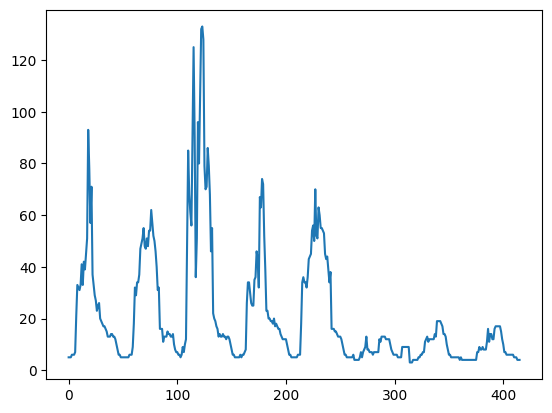

In [19]:
df_test.total_cases.plot()

<Axes: >

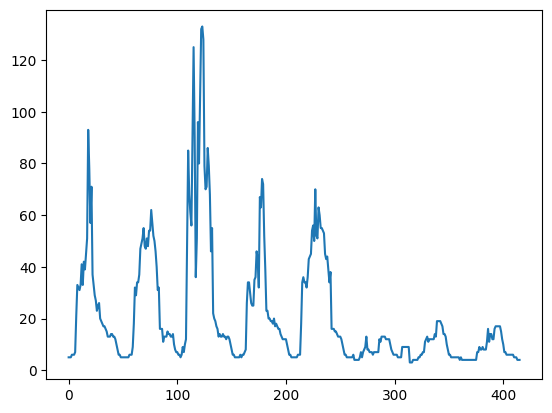

In [20]:
submissions.total_cases.plot()

In [21]:
pd.concat([df_train, labels['total_cases']], axis=1).corr()['total_cases'].sort_values(ascending=False)

total_cases                                        1.000000
station_min_temp_c_rolling_6                       0.378851
reanalysis_min_air_temp_k_rolling_6                0.361569
reanalysis_min_air_temp_k_rolling_4                0.351470
station_min_temp_c_rolling_4                       0.345545
reanalysis_air_temp_k_rolling_6                    0.339931
reanalysis_min_air_temp_k_rolling_2                0.337498
reanalysis_min_air_temp_k                          0.325252
reanalysis_air_temp_k_rolling_4                    0.314495
station_min_temp_c_rolling_2                       0.301732
sj                                                 0.292624
reanalysis_air_temp_k_rolling_2                    0.285120
station_min_temp_c                                 0.267109
reanalysis_air_temp_k                              0.264952
reanalysis_avg_temp_k_rolling_6                    0.236424
station_avg_temp_c_rolling_6                       0.222843
weekofyear                              

In [52]:
X.to_csv('../data/04_feature/X_modeling_RollingVars.csv',sep=',')


In [29]:
X.head()

,year,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,station_avg_temp_c_rolling_4,reanalysis_tdtr_k_rolling_6,reanalysis_sat_precip_amt_mm_rolling_6,reanalysis_min_air_temp_k_rolling_6,station_min_temp_c_rolling_6,reanalysis_air_temp_k_rolling_6,reanalysis_avg_temp_k_rolling_6,reanalysis_dew_point_temp_k_rolling_6,reanalysis_specific_humidity_g_per_kg_rolling_6,station_avg_temp_c_rolling_6
0,1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,26.585714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,27.460714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
X.columns

Index(['year', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'sj', 'iq', 'week_sin',
       'week_cos', 'reanalysis_tdtr_k_rolling_2',
       'reanalysis_sat_precip_amt_mm_rolling_2',
       'reanalysis_min_air_temp_k_rolling_2', 'station_min_temp_c_rolling_2',
       'reanalysis_air_temp_k_rolling_2', 'reanalysis_avg_temp_k_rolling_2',
       'reanalysis_dew_point_temp_k_rolling_2',
       'reanalysis_specific_humidity_g_per_kg_rolling_2',
       'station_avg_temp_c_rolling_2', 'reanalysis_tdtr

In [43]:
labels.columns

Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')

In [50]:
import matplotlib.pyplot as plt

df = X.copy()
# Step 1: Filter the DataFrame for the desired city
desired_city = 'sj'
city_df = df[(df[desired_city] == 1)]

# Step 2: Extract relevant columns
total_cases = labels[(labels['city']=='sj')].total_cases
temperature = city_df['reanalysis_min_air_temp_k']-273  # You can choose any temperature column
precipitation = city_df['precipitation_amt_mm']
station_min_temp_c_rolling_6 = 400*np.standard(city_df['station_min_temp_c_rolling_6'] + 273)
# Step 3: Plot the data
plt.figure(figsize=(10, 6))

# Plot total cases
plt.plot(total_cases, label='Total Cases')

# Plot temperature
plt.plot(temperature, label='Temperature (K)')

# Plot temperature
plt.plot(station_min_temp_c_rolling_6, label='Temperature (K)')

# # Plot precipitation
# plt.plot(precipitation, label='Precipitation (mm)')

# Customize plot
plt.title('Total Cases, Temperature, and Precipitation Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.show()

AttributeError: module 'numpy' has no attribute 'standard'

In [22]:
df.head(2)

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,station_avg_temp_c_rolling_4,reanalysis_tdtr_k_rolling_6,reanalysis_sat_precip_amt_mm_rolling_6,reanalysis_min_air_temp_k_rolling_6,station_min_temp_c_rolling_6,reanalysis_air_temp_k_rolling_6,reanalysis_avg_temp_k_rolling_6,reanalysis_dew_point_temp_k_rolling_6,reanalysis_specific_humidity_g_per_kg_rolling_6,station_avg_temp_c_rolling_6
0,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990,19,0.1699,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_train_rolling = pd.read_csv('..data/04_feature/X_modeling_RollingVars.csv')
df_train_rolling_sj = df_train_rolling.query("sj==1 and source == 'train'")
df_train_rolling_iq = df_train_rolling.query("iq==1 and source == 'train'")
df_train_all_temps_rolling_sj = df_train_rolling_sj[['year','reanalysis_air_temp_k_rolling_2']]
df_train_all_temps_rolling_iq = df_train_rolling_iq[['year','reanalysis_air_temp_k_rolling_2']]
df_train_all_temps_rolling_sj = df_train_rolling_sj.query("weekofyear % 2 == 0")
df_train_all_temps_rolling_iq = df_train_rolling_iq.query("weekofyear % 2 == 0")
fig, ax = plt.subplots(1,2, figsize=(30, 10))
ax[0].set_title('Temperature readings vs. total cases in San Juan', fontsize = 24)
sns.lineplot(df_train_all_temps_rolling_sj, x='year', y='reanalysis_air_temp_k_rolling_2', label='reanalysis_air_temp_k (rolling average 2 weeks)', ax=ax[0])
ax[0].set_xlabel('Year', fontsize=20)
ax[0].set_ylabel('Temperature reading (k)',fontsize=20)
ax2 = ax[0].twinx()
sns.lineplot(labels_train_sj, x='year', y='total_cases', label='total_cases', ax=ax2, color='r')
ax2.set_ylabel('total_cases',fontsize=20)
ax1[0].legend()
ax[1].set_title('Temperature readings vs total cases in Iquitos', fontsize = 30)
sns.lineplot(df_train_all_temps_rolling_iq, x='year', y='reanalysis_air_temp_k_rolling_2', label='reanalysis_air_temp_k (rolling average 2 weeks)', ax=ax[1])
ax[1].set_xlabel('Year', fontsize=20)
ax[1].set_ylabel('Temperature reading (k)', fontsize=20)
ax3 = ax[1].twinx()
sns.lineplot(labels_train_iq, x='year', y='total_cases', label='total cases', ax=ax3, color='r')
ax3.set_ylabel('total_cases',fontsize=20)
ax[1].legend()
fig.tight_layout()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

